In [60]:
# import basic libraries 
import pandas as pd
from textblob import TextBlob
import nltk
nltk.download('stopwords')
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import re
import string

# read csv
df = pd.read_csv('../data/data_clean.csv')
df_copy = df.copy()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lilmac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Sentiment scores in new column

In [114]:
df['text'] = df['text'].astype(str)

In [115]:
text_list = df['text'].tolist()

In [116]:
text_list[0]

'Hang told me to add it in education'

In [118]:
#load the descriptions into textblob
post_blob = [TextBlob(desc) for desc in text_list]
df['tb_Pol'] = [b.sentiment.polarity for b in post_blob]
df['tb_Subj'] = [b.sentiment.subjectivity for b in post_blob]
df.head()

,channel_name,user,real_name,text,text_length,reply_count,reply_users_count,replies_true,day_name,day_type,...,day_number,month,reactions_count,link_of_file,files_true,link_of_attachments,attachments_true,reaction_true,tb_Pol,tb_Subj
0,general,U01S79YDELR,Karina Condeixa,Hang told me to add it in education,35,0,0,False,Sunday,Weekend,...,9,May,0,nofile,False,nolink,False,False,0.00000,0.000000
1,general,U01S79YDELR,Karina Condeixa,What improved my score was adding metrics of a...,98,0,0,False,Sunday,Weekend,...,9,May,0,nofile,False,nolink,False,False,0.00000,0.000000
2,general,U01RRV4JX6Z,Francisco Ebeling,I feel like a slave to this dumb Resume Worded...,261,31,2,True,Sunday,Weekend,...,9,May,0,nofile,False,nolink,False,False,-0.04881,0.445068
3,general,U01S79YDELR,Karina Condeixa,"Francisco, we have to remove the fancy/beautif...",76,0,0,False,Sunday,Weekend,...,9,May,0,nofile,False,nolink,False,False,0.00000,0.000000
4,general,U01RRV4JX6Z,Francisco Ebeling,"Ah, ok!",7,0,0,False,Sunday,Weekend,...,9,May,0,nofile,False,nolink,False,False,0.62500,0.500000


In [112]:
type(text_list)

list

In [119]:
# load VADER
analyzer = SentimentIntensityAnalyzer()
# add VADER metrics to dataframe
df['compound'] = [analyzer.polarity_scores(v)['compound'] for v in text_list]
df['neg'] = [analyzer.polarity_scores(v)['neg'] for v in text_list]
df['neu'] = [analyzer.polarity_scores(v)['neu'] for v in text_list]
df['pos'] = [analyzer.polarity_scores(v)['pos'] for v in text_list]

In [121]:
df.head()

,channel_name,user,real_name,text,text_length,reply_count,reply_users_count,replies_true,day_name,day_type,...,files_true,link_of_attachments,attachments_true,reaction_true,tb_Pol,tb_Subj,compound,neg,neu,pos
0,general,U01S79YDELR,Karina Condeixa,Hang told me to add it in education,35,0,0,False,Sunday,Weekend,...,False,nolink,False,False,0.00000,0.000000,0.0000,0.000,1.000,0.000
1,general,U01S79YDELR,Karina Condeixa,What improved my score was adding metrics of a...,98,0,0,False,Sunday,Weekend,...,False,nolink,False,False,0.00000,0.000000,0.6908,0.000,0.695,0.305
2,general,U01RRV4JX6Z,Francisco Ebeling,I feel like a slave to this dumb Resume Worded...,261,31,2,True,Sunday,Weekend,...,False,nolink,False,False,-0.04881,0.445068,-0.4363,0.153,0.760,0.086
3,general,U01S79YDELR,Karina Condeixa,"Francisco, we have to remove the fancy/beautif...",76,0,0,False,Sunday,Weekend,...,False,nolink,False,False,0.00000,0.000000,0.0000,0.000,1.000,0.000
4,general,U01RRV4JX6Z,Francisco Ebeling,"Ah, ok!",7,0,0,False,Sunday,Weekend,...,False,nolink,False,False,0.62500,0.500000,0.0000,0.000,1.000,0.000


In [135]:
# save to excel
df.to_excel(r'../data/data_clean_nlp.xlsx', index = False)

### Wordcloud

In [52]:
# change the text type to string
df['text'] = df['text'].astype(str)

# before lowercasing 
df['text'][2]

# lowercase all reviews
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['text'][2] ## to see the difference


"i feel like a slave to this dumb resume worded algorithm. it simply doesn't like the format i chose and i had to stick to a very lean one column cv. imagine in the future, when much more serious decisions will be made by algorithms with serious flaws like this."

In [53]:
# remove punctuation
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
df['text'] = df['text'].apply(remove_punctuations)
df['text'][2]

'i feel like a slave to this dumb resume worded algorithm it simply doesnt like the format i chose and i had to stick to a very lean one column cv imagine in the future when much more serious decisions will be made by algorithms with serious flaws like this'

In [54]:
# remove stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['text'][2]

'feel like slave dumb resume worded algorithm simply doesnt like format chose stick lean one column cv imagine future much serious decisions made algorithms serious flaws like'

In [141]:
# stemming
#stemmer = PorterStemmer()
#df['text'] = df['text'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
#df['text'][2]

#df['text']=df['text'].apply(lambda x: " ".join((stemmer.stem(i) for i in x.split())))
#df['text'][2]


In [142]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

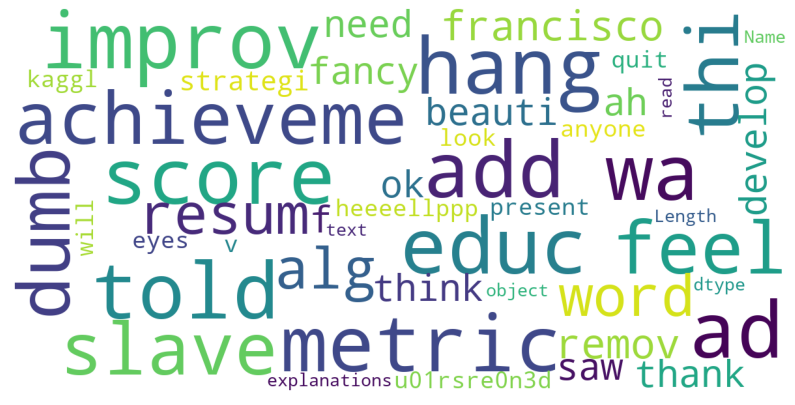

In [143]:
def show_wordcloud(col, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(col))

    fig = plt.figure(1, figsize=(14, 14))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


if __name__ == '__main__':

    show_wordcloud(df['text'])

In [130]:
# most common words
import collections
from collections import Counter
import itertools


# List of all words across tweets
all_words = list(itertools.chain(*text_list))

# Create counter
counts = collections.Counter(all_words)

counts.most_common(15)

[(' ', 68305),
 ('e', 38148),
 ('t', 33168),
 ('o', 27913),
 ('a', 27192),
 ('i', 23778),
 ('n', 22985),
 ('s', 22471),
 ('r', 18277),
 ('h', 16506),
 ('l', 15113),
 ('d', 11540),
 ('u', 11398),
 ('c', 10691),
 ('m', 9618)]